In [2]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # its VERY IMPORTANT this says cuda
print(DEVICE)
import torchaudio
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F


from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Audio
import math
import os
from torchinfo import summary
import json
from itertools import product
import time
import re
import shutil
import soundfile as sf 
import gc
from datetime import datetime
import numpy as np
import random
from pesq import pesq
from pystoi import stoi

cuda


# Dataset creation

#### Dataset

In [3]:
class WavDataset(Dataset):
    """
    A dataset that lazily loads WAV files from
    x directory and y directory from a list
    with the relative paths of the files.
    
    Args:
        x_files, y_files
    
    Returns:
        waveform (torch.Tensor): Tensor containing the waveform.
        filename (str): Name of the file without the extension.
        
    """
    
    def __init__(self, x_files, y_files):
        assert len(x_files) == len(y_files), "Inputs and targets must match"
        self.x_files = x_files
        self.y_files = y_files
        
    def __len__(self):
        return len(self.x_files)
    
    def __getitem__(self, index):
        wav_path = self.x_files[index]
        waveform_x, _ = torchaudio.load(wav_path)
        filename_x = wav_path.stem

        wav_path = self.y_files[index]
        waveform_y, _ = torchaudio.load(wav_path)
        filename_y = wav_path.stem

        return waveform_x, filename_x, waveform_y, filename_y


## Dataset analysis
| Training Dataset (s) | Test Dataset (s) | Range | Noise |
| - | - | - | - |
| Max: 15.11 <br> Min: 1.09 <br> Avg: 2.92 | Max: 9.76 <br> Min: 1.23 <br> Avg: 2.51 | Waveforms normalized to [-1,1] | Noise is real, not randomly generated|

#### Conclusion

If padding was applied to 20 s (20*48000=960000), tensors would be too big, need to downsample to 16kHz, no need to normalize data, the model must be able to handle this type of noise.

In [4]:
# dataset_dir = "../data/clean_trainset_28spk_wav"
# dataset = WavDataset(dataset_dir)
# loader = DataLoader(dataset, batch_size=1, num_workers=1,shuffle=False)

# def analysis(x):
#     return len(x[0].squeeze())/48000

# lengths = []
# for batch in loader:
#     lengths.append(analysis(batch))

# print('Training Dataset')
# print('Max length',max(lengths))
# print('Min length',min(lengths))
# print('Avg length',sum(lengths)/len(lengths))

In [5]:
# dataset_dir = "../data/clean_testset_wav"
# dataset = WavDataset(dataset_dir)
# loader = DataLoader(dataset, batch_size=1, num_workers=1,shuffle=False)

# lengths = []
# for batch in loader:
#     lengths.append(analysis(batch))
    
# print('Test Dataset')
# print('Max length',max(lengths))
# print('Min length',min(lengths))
# print('Avg length',sum(lengths)/len(lengths))

In [6]:
# clean_dataset_dir = "../data/clean_testset_wav"
# clean_dataset = WavDataset(clean_dataset_dir)
# clean_wav = clean_dataset[0][0].squeeze()

# noisy_dataset_dir = "../data/noisy_testset_wav"
# noisy_dataset = WavDataset(noisy_dataset_dir)
# noisy_wav = noisy_dataset[0][0].squeeze()

# fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# ax[0].plot(clean_wav)
# ax[0].set_title("Clean Audio")

# ax[1].plot(noisy_wav)
# ax[1].set_title("Noisy Audio")

# plt.show()

# display(Audio(clean_wav, rate=48000))
# display(Audio(noisy_wav, rate=48000))

## Train/Val/Test Split


#### Resampling by rate and filter by duration

In [7]:
SRC_ROOT_48K = Path("../data")          # original 48 kHz root
DST_ROOT_16K = Path("../data_16k")      # downsampled root
FREQ = 16000                            # target sample rate
SECONDS = 3.2                           # max duration to keep (seconds)

FOLDERS = [
    "clean_trainset_28spk_wav",
    "noisy_trainset_28spk_wav",
    "clean_testset_wav",
    "noisy_testset_wav",
]


# ---------- STEP 1: DOWNSAMPLING ----------
def resample_folder_by_rate(src_dir: Path, dst_dir: Path, target_sr: int = FREQ):
    dst_dir.mkdir(parents=True, exist_ok=True)

    example_files = list(src_dir.glob("*.wav"))
    if not example_files:
        print(f"[WARN] No wav files in {src_dir}")
        return

    _, orig_sr = torchaudio.load(example_files[0])
    if orig_sr == target_sr:
        print(f"[INFO] {src_dir} already at {orig_sr} Hz, copying as-is.")
        resampler = None
    else:
        print(f"[INFO] Resampling {src_dir} from {orig_sr} Hz to {target_sr} Hz")
        resampler = torchaudio.transforms.Resample(orig_sr, target_sr)

    for wav_path in sorted(src_dir.glob("*.wav")):
        dst_path = dst_dir / wav_path.name

        if dst_path.exists():
            continue  # skip already processed

        waveform, sr = torchaudio.load(wav_path)
        if resampler is not None:
            waveform = resampler(waveform)

        torchaudio.save(dst_path, waveform, target_sr)

    print(f"[DONE] {src_dir} -> {dst_dir}")


def downsample_all():
    for folder in FOLDERS:
        src_dir = SRC_ROOT_48K / folder
        dst_dir = DST_ROOT_16K / folder
        if not src_dir.exists():
            print(f"[SKIP] Source directory not found: {src_dir}")
            continue
        resample_folder_by_rate(src_dir, dst_dir)


# ---------- STEP 2: FILTER BY DURATION (ON 16 kHz DATA) ----------
def filter_by_duration(src_dir: Path, max_duration_sec: float, target_sr: int = FREQ):
    """
    Returns list of wav files in src_dir with duration <= max_duration_sec
    and sample rate == target_sr.
    """
    wav_files = list(src_dir.glob("*.wav"))
    if not wav_files:
        print(f"[WARN] No wav files in {src_dir}")
        return []

    kept_files = []

    for wav_path in sorted(wav_files):
        try:
            info = sf.info(wav_path)
            duration = info.duration

            if info.samplerate != target_sr:
                print(f"[SKIP] {wav_path.name}: wrong SR {info.samplerate}, expected {target_sr}")
                continue
        except Exception as e:
            print(f"[ERROR] Could not read {wav_path}: {e}")
            continue

        if duration <= max_duration_sec:
            kept_files.append(wav_path)

    print(f"[DONE] {src_dir} | Kept {len(kept_files)}/{len(wav_files)} files")
    return kept_files


def build_kept_files_dict():
    """
    Runs duration filtering on the already-downsampled data_16k and
    returns a dict: {folder_name: [Path(...), ...], ...}
    """
    kept_files_by_folder = {}
    total_kept = 0
    total_files = 0

    for folder in FOLDERS:
        src_dir = DST_ROOT_16K / folder

        if not src_dir.exists():
            print(f"[SKIP] Source directory not found: {src_dir}")
            continue

        kept = filter_by_duration(src_dir, SECONDS, FREQ)
        kept_files_by_folder[folder] = kept
        total_kept += len(kept)
        total_files += len(list(src_dir.glob("*.wav")))

    print("\n=== SUMMARY ===")
    print(f"Total kept: {total_kept}/{total_files} files")

    return kept_files_by_folder


In [8]:
downsample_all()

[INFO] Resampling ../data/clean_trainset_28spk_wav from 48000 Hz to 16000 Hz
[DONE] ../data/clean_trainset_28spk_wav -> ../data_16k/clean_trainset_28spk_wav
[INFO] Resampling ../data/noisy_trainset_28spk_wav from 48000 Hz to 16000 Hz
[DONE] ../data/noisy_trainset_28spk_wav -> ../data_16k/noisy_trainset_28spk_wav
[INFO] Resampling ../data/clean_testset_wav from 48000 Hz to 16000 Hz
[DONE] ../data/clean_testset_wav -> ../data_16k/clean_testset_wav
[INFO] Resampling ../data/noisy_testset_wav from 48000 Hz to 16000 Hz
[DONE] ../data/noisy_testset_wav -> ../data_16k/noisy_testset_wav


#### Dataloader: collate function, splitting function

In [9]:
def collate_fn(batch):
    # batch is a list of tuples:
    # (waveform_x, filename_x, waveform_y, filename_y)
    waveform_x_list, filename_x_list, waveform_y_list, filename_y_list = zip(*batch)

    # Assume torchaudio.load → waveform: [channels, samples]
    # Convert to [samples] (mono) by squeezing channel dim
    xs = [w.squeeze(0) for w in waveform_x_list]
    ys = [w.squeeze(0) for w in waveform_y_list]

    batch_size = len(xs)
    target_len = int(SECONDS * FREQ)

    # Allocate padded tensors [batch, target_len]
    x_padded = torch.zeros(batch_size, target_len)
    y_padded = torch.zeros(batch_size, target_len)

    # Truncate or pad each waveform
    for i, (x, y) in enumerate(zip(xs, ys)):
        x_len = min(x.shape[0], target_len)
        y_len = min(y.shape[0], target_len)

        x_padded[i, :x_len] = x[:x_len]
        y_padded[i, :y_len] = y[:y_len]

    # Add channel dimension: [batch, 1, target_len]
    x_padded = x_padded.unsqueeze(1)
    y_padded = y_padded.unsqueeze(1)

    return x_padded, y_padded, list(filename_x_list), list(filename_y_list)

def create_split(
    batch_size,
    num_workers,
    sample_size,
    noisy_train_files,
    clean_train_files,
    noisy_test_files,
    clean_test_files,
    ratio=0.9,
    seed=time.time(),
):
    """
    Create train/val/test dataloaders from paired audio files.
    
    Args:
        batch_size: Batch size for DataLoader
        num_workers: Number of workers for DataLoader
        sample_size: Limit number of training samples (None = use all)
        noisy_train_files: List of noisy train file paths
        clean_train_files: List of clean train file paths
        noisy_test_files: List of noisy test file paths
        clean_test_files: List of clean test file paths
        ratio: Train/val split ratio (default 0.9)
        seed: Random seed for reproducibility
    
    Returns:
        train_loader, val_loader, test_loader
    """
    torch.manual_seed(seed)
    
    # Limit sample size if specified
    actual_size = min(sample_size, len(noisy_train_files)) if sample_size is not None else len(noisy_train_files)

    # Train/val split
    indices = torch.randperm(len(noisy_train_files))[:actual_size] # take slice from jumbled list
    train_size = int(ratio * actual_size)    
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    # Split file lists (keeping pairs matched)
    x_train_files = [noisy_train_files[i] for i in train_indices]
    y_train_files = [clean_train_files[i] for i in train_indices]
    x_val_files = [noisy_train_files[i] for i in val_indices]
    y_val_files = [clean_train_files[i] for i in val_indices]
    
    # Create paired datasets
    train_dataset = WavDataset(x_train_files, y_train_files)
    val_dataset = WavDataset(x_val_files, y_val_files)
    test_dataset = WavDataset(noisy_test_files, clean_test_files)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )
    
    return train_loader, val_loader, test_loader


# Denoising

## Models

In [10]:
class Wave_UNet(nn.Module):
    """
    Implements Wave-U-Net, meaning it employs 1D convolutions in a 
    encode-decode structure that takes raw audio and denoises it.
    It uses LeakyReLU as the activation function except 
    in the last layer which is tanh.

    To reduce noise artifacts, no transpose convolutions are used,
    and the convolutions are set to 0 padding. To compensate for
    this, the waveforms are padded with 0s. 

    Regarding how the time domain is shrunk and expanded, decimate
    is used for downsampling and a custom interpolation function is 
    usd for upsampling. Notably, it doesn't extrapolate, meaning
    the output is actually 2n-1 instead of the usual 2n.

    DISCLAIMER:
    A short waveform paired with a high depth will NOT work. Beware.
    """
    def __init__(self, depth=12, base_filters=24): # add transformation function
        super().__init__()
        self.depth = depth
        self.padding = self.compute_padding()

        # Encoder
        self.encoders = nn.ModuleList()
        in_ch = 1 
        for i in range(depth): # 0 -> depth-1
            out_ch = base_filters * (i + 1)
            self.encoders.append(self.EncoderBlock(in_ch, out_ch))
            in_ch = out_ch
        
        # Mid convolution, which has no decimation
        out_ch = in_ch+base_filters
        self.mid_conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size = 15, padding=0),
            nn.LeakyReLU()
        )
        in_ch = out_ch

        # Decoder
        self.decoders = nn.ModuleList()
        for i in range(depth-1, 0, -1): # depth-1 -> 1 for the staggered interpolation
            out_ch = base_filters * (i + 1)
            self.decoders.append(self.DecoderBlock(in_ch, out_ch, out_ch))
            in_ch = out_ch

        # staggered interpolation, fix this
        self.StaggeredBlock = nn.Sequential(
            nn.Upsample(scale_factor=2,mode='linear',align_corners=True),
            nn.Conv1d(in_ch+base_filters, base_filters, kernel_size = 15, padding=0),
            nn.LeakyReLU()
        )

        
        self.final_conv = nn.Conv1d(base_filters+1, 1, kernel_size=1, padding=0) # finale, kernel size 1 conv, from base_filters+1 -> 1
         
    def forward(self, x):
        original = x # for the finale
        x = F.pad(x, (self.padding, self.padding), mode='constant', value=0) 

        # DOWNSAMPLER
        skips = []
        for enc in self.encoders:
            x, skip = enc(x)
            skips.append(skip)

        x = self.mid_conv(x) # mid conv

        # UPSAMPLER
        for dec in self.decoders:
            skip = self.center_crop(skips.pop(),(x.shape[-1]*2)-1)
            x = dec(x, skip)

        # Staggered upsampler
        # add center crop
        skip = self.center_crop(skips.pop(), x.shape[-1])
        x = torch.cat([skip, x], dim=1)
        x = self.StaggeredBlock(x)
        
        x = self.center_crop(x, original.shape[-1])
        x = torch.cat([x, original], dim=1)
        x = self.final_conv(x) # finale + tanh activation function
        return x
    
    class EncoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.conv = nn.Conv1d(in_channels, out_channels, 
                                  kernel_size=15, padding=0) # padding_mode='zeros'
            self.leaky_relu = nn.LeakyReLU()
            self.decimate = Wave_UNet.Decimate2()

        def forward(self, x):
            x = self.conv(x)
            x = self.leaky_relu(x)
            skip = x
            x = self.decimate(x)
            return x, skip
        
    class DecoderBlock(nn.Module):
        def __init__(self, in_channels, skip_channels, out_channels):
            super().__init__()
            self.upsample = Wave_UNet.Interpolate2()
            self.conv = nn.Conv1d(in_channels+skip_channels, out_channels, 
                                    kernel_size=5, padding=0) 
            self.leaky_relu = nn.LeakyReLU()
            
        def forward(self, x, skip):
            x = self.upsample(x)
            x = torch.cat([x, skip], dim=1)
            x = self.conv(x)
            x = self.leaky_relu(x)
            return x
    
    class Decimate2(nn.Module): # cuts size in half by skipping every other step
        def __init__(self):
            super().__init__()
        def forward(self, x):
            return x[..., ::2]
    
    class Interpolate2(nn.Module): # it differs to Upsample by having a 2n-1 output size
        def __init__(self,):
            super().__init__()
        def forward(self, x):
            # remember, input is a batch
            T = x.shape[-1]
            out_shape = list(x.shape)
            out_shape[-1] = 2 * T - 1
            # calculate interpolation
            output = torch.empty(out_shape, device=x.device, dtype=x.dtype) 
            output[...,::2] = x
            output[...,1::2] = 0.5 * (x[..., :-1] + x[..., 1:])
            return output
        
    def compute_padding(self):
        # Makes a estimate of how much padding is needed on each side 
        # of each tendor to compensate for padding=0. 
        # Takes the reverse route of the Wave U-Net
        padding = 0 # initialize

        # UPSAMPLER
        # staggered interpolation
        padding += 4 # conv
        padding = math.ceil(padding/2) # interpolation

        for _ in range(self.depth-1):
            padding += 4 # conv
            padding = math.ceil((padding+1)/2 ) # interpolation

        padding += 14 # mid conv

        # DOWNSAMPLER
        for _ in range(self.depth):
            padding = 2*padding # decimate
            padding += 14 # conv
        
        return int(padding/2) # F.pad doesnt take float
    
    def center_crop(self, x, target_len):
        # x is (B, C, T), target_len is int
        current_len = x.shape[-1]
        diff = current_len - target_len
        if diff == 0: return x
        if diff < 0: raise ValueError("Target bigger than input!")
        start = diff // 2
        end = start + target_len
        return x[..., start:end]
    
     
    

In [11]:
class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dilation=1):
        super().__init__()
        self.conv1x1_in = nn.Conv2d(in_ch, out_ch, kernel_size=1, padding=0)
        self.conv3x3 = nn.Conv2d(
            out_ch, out_ch, kernel_size=3,
            padding=dilation, dilation=dilation
        )
        self.prelu = nn.PReLU()
        self.bn = nn.BatchNorm2d(out_ch)
        self.conv1x1_out = nn.Conv2d(out_ch, out_ch, kernel_size=1, padding=0)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.conv1x1_in(x)
        x = self.conv3x3(x)
        x = self.prelu(x)
        x = self.bn(x)
        x = self.conv1x1_out(x)
        skip = x
        x = self.pool(x)
        return x, skip

class DecoderBlock(nn.Module):
    def __init__(self):
        super().__init__()
        # upconv will be set per block when UNet is built
        self.upconv = None
        self.conv1 = None
        self.bn1 = None
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = None
        self.bn2 = None
        self.relu2 = nn.ReLU(inplace=True)

    def center_crop(self, x, th, tw):
        h, w = x.shape[-2:]
        dh, dw = h - th, w - tw
        if dh == 0 and dw == 0:
            return x
        sh, sw = dh // 2, dw // 2
        return x[..., sh:sh+th, sw:sw+tw]

    def forward(self, x, skip):
        x = self.upconv(x)

        if x.shape[-2:] != skip.shape[-2:]:
            skip = self.center_crop(skip, x.shape[-2], x.shape[-1])

        x = torch.cat([x, skip], dim=1)             # (B, C_cat, H, W)
        C_cat = x.shape[1]

        # lazily build convs with correct channel sizes
        if self.conv1 is None:
            self.conv1 = nn.Conv2d(C_cat, C_cat, kernel_size=3, padding=1).to(x.device)
            self.bn1 = nn.BatchNorm2d(C_cat).to(x.device)
        if self.conv2 is None:
            out_ch = skip.shape[1]
            self.conv2 = nn.Conv2d(C_cat, out_ch, kernel_size=3, padding=1).to(x.device)
            self.bn2 = nn.BatchNorm2d(out_ch).to(x.device)

        x = self.conv1(x); x = self.relu1(x); x = self.bn1(x)
        x = self.conv2(x); x = self.relu2(x); x = self.bn2(x)
        return x

class UNet(nn.Module):
    def __init__(self, encoder_channels=None,
                 forward_transform=None,
                 inverse_transform=None,
                 in_channels=1):
        super().__init__()

        if encoder_channels is None:
            encoder_channels = [32, 64, 128, 256, 256, 512, 512]
        self.channels = encoder_channels

        assert forward_transform is not None
        assert inverse_transform is not None
        self.forward_transform = forward_transform
        self.inverse_transform = inverse_transform

        # Encoder
        self.encoders = nn.ModuleList()
        in_ch = in_channels
        for ch in self.channels:
            self.encoders.append(EncoderBlock(in_ch, ch))
            in_ch = ch

        # Decoder (igual que antes)
        self.decoders = nn.ModuleList()
        dec_in_ch = self.channels[-1]
        for skip_ch in reversed(self.channels):
            block = DecoderBlock()
            block.upconv = nn.ConvTranspose2d(dec_in_ch, dec_in_ch, kernel_size=2, stride=2)
            self.decoders.append(block)
            dec_in_ch = skip_ch

        self.final_conv = nn.Conv2d(dec_in_ch, 1, kernel_size=1, padding=0)

    def forward(self, noisy_waveform):
        aux, spec = self.forward_transform(noisy_waveform)   # aux: (B,3,F,T) ahora

        B, C, F_orig, T_orig = aux.shape

        div = 2 ** len(self.channels)
        F_crop = (F_orig // div) * div
        T_crop = (T_orig // div) * div
        aux_c = aux[:, :, :F_crop, :T_crop]

        x = aux_c
        skips = []
        for enc in self.encoders:
            x, skip = enc(x)
            skips.append(skip)

        for dec in self.decoders:
            x = dec(x, skips.pop())

        enh_aux_c = self.final_conv(x)  # (B,1,F_crop,T_crop)

        enh_aux = F.interpolate(
            enh_aux_c,
            size=(F_orig, T_orig),
            mode="bilinear",
            align_corners=False,
        )
        mask = torch.sigmoid(enh_aux)   # (B,1,F,T)

        enhanced = self.inverse_transform(mask, aux, spec)
        return enhanced


#### U-Net modules

In [12]:
# STFT 
class STFTMag(nn.Module):
    def __init__(self, n_fft=1024, hop_length=160, win_length=400):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        window = torch.hann_window(win_length)
        self.register_buffer("window", window)

    def forward(self, waveform):
        B, C, T = waveform.shape
        assert C == 1
        spec = torch.stft(
            waveform.squeeze(1),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=True,
            return_complex=True,
        )
        mag = spec.abs()                      # (B,F,T)
        return mag.unsqueeze(1), spec         # (B,1,F,T), complex STFT

class ISTFTMask(nn.Module):
    def __init__(self, n_fft=1024, hop_length=160, win_length=400):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        window = torch.hann_window(win_length)
        self.register_buffer("window", window)

    def forward(self, mask, mag, phase):
        # mask: (B,1,F,T), mag: (B,1,F,T), phase: (B,F,T) complex
        mag_enh = (mask * mag).squeeze(1)          # (B,F,T)
        complex_spec = mag_enh * phase / (phase.abs() + 1e-12)
        wav = torch.istft(
            complex_spec,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=True,
        )
        return wav.unsqueeze(1)


In [13]:
# Mel
class MelMag(nn.Module):
    def __init__(self, sample_rate=16000,
                 n_fft=1024, hop_length=160, win_length=400,
                 n_mels=256):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length

        window = torch.hann_window(win_length)
        self.register_buffer("window", window)

        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=win_length,
            n_mels=n_mels,
            power=1.0,        # magnitude, como STFTMag
        )

    def forward(self, waveform):
        # waveform: (B,1,T)
        B, C, T = waveform.shape
        assert C == 1

        # 1) STFT para fase
        spec = torch.stft(
            waveform.squeeze(1),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window.to(waveform.device),
            center=True,
            return_complex=True,
        )                                   # (B,F,T_spec)

        # 2) magnitud mel desde waveform
        mel_mag = self.mel_spec(waveform.squeeze(1))   # (B,M,T_mel)

        return mel_mag.unsqueeze(1), spec              # (B,1,M,T), phase/spec

class InvMelMagMask(nn.Module):
    def __init__(self, sample_rate=16000,
                 n_fft=1024, hop_length=160, win_length=400,
                 n_mels=256):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length

        window = torch.hann_window(win_length)
        self.register_buffer("window", window)

        self.mel_inv = torchaudio.transforms.InverseMelScale(
            n_stft=n_fft // 2 + 1,
            n_mels=n_mels,
            sample_rate=sample_rate,
        )

    def forward(self, mask, mel_mag, phase):
        # mask, mel_mag: (B,1,M,Tm)
        mel_mag_enh = (mask * mel_mag).squeeze(1)   # (B,M,Tm)

        # volver a magnitud lineal
        lin_mag = self.mel_inv(mel_mag_enh)         # (B,F,T)

        complex_spec = lin_mag * phase / (phase.abs() + 1e-12)
        wav = torch.istft(
            complex_spec,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window.to(phase.device),
            center=True,
        )
        return wav.unsqueeze(1)

In [14]:
# STFT_PHASE
class STFTMagPhase(nn.Module):
    def __init__(self, n_fft=1024, hop_length=160, win_length=400):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        window = torch.hann_window(win_length)
        self.register_buffer("window", window)

    def forward(self, waveform):
        # waveform: (B,1,T)
        B, C, T = waveform.shape
        assert C == 1

        spec = torch.stft(
            waveform.squeeze(1),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=True,
            return_complex=True,
        )                      # (B,F,T), complex

        mag = spec.abs()       # (B,F,T)
        phase = torch.angle(spec)  # (B,F,T)
        cos_p = torch.cos(phase)
        sin_p = torch.sin(phase)

        # apilamos como canales: [mag, cos(phase), sin(phase)]
        aux = torch.stack([mag, cos_p, sin_p], dim=1)  # (B,3,F,T)

        return aux, spec       # aux features, spec para reconstrucción

class ISTFTMaskFromAux(nn.Module):
    def __init__(self, n_fft=1024, hop_length=160, win_length=400):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        window = torch.hann_window(win_length)
        self.register_buffer("window", window)

    def forward(self, mask, aux, phase):
        """
        mask: (B,1,F,T)   - salida de la UNet (sigmoid)
        aux:  (B,3,F,T)   - [mag, cos, sin] de la STFT ruidosa
        phase: (B,F,T) complex STFT (spec)
        """
        mag = aux[:, 0, :, :]             # (B,F,T) magnitud original
        mag_enh = (mask.squeeze(1) * mag) # (B,F,T)

        complex_spec = mag_enh * phase / (phase.abs() + 1e-12)
        wav = torch.istft(
            complex_spec,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window.to(phase.device),
            center=True,
        )
        return wav.unsqueeze(1)           # (B,1,T)



In [15]:
# Mel_PHASE
class MelMagPhase(nn.Module):
    def __init__(self, sample_rate=16000,
                 n_fft=1024, hop_length=160, win_length=400,
                 n_mels=256):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length

        window = torch.hann_window(win_length)
        self.register_buffer("window", window)

        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=win_length,
            n_mels=n_mels,
            power=1.0,        # magnitud
        )

        # Para “mapear” fase STFT a rejilla mel usaremos el banco mel
        self.mel_fb = self.mel_spec.mel_scale.fb  # (M, F)

    def forward(self, waveform):
        # waveform: (B,1,T)
        B, C, T = waveform.shape
        assert C == 1

        # 1) STFT complejo para fase
        spec = torch.stft(
            waveform.squeeze(1),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window.to(waveform.device),
            center=True,
            return_complex=True,
        )                               # (B,F,T)

        mag = spec.abs()                # (B,F,T)
        phase = torch.angle(spec)       # (B,F,T)
        cos_p = torch.cos(phase)
        sin_p = torch.sin(phase)

        # 2) mel magnitud desde waveform
        mel_mag = self.mel_spec(waveform.squeeze(1))   # (B,M,Tm)

        # 3) proyectar cos/sin al eje mel (lineal→mel) usando mismo banco
        # mel_fb: (M,F). Queremos (B,M,Tm) aprox, asumimos Tm ≈ T
        fb = self.mel_fb.to(waveform.device)           # (M,F)

        # multiplicar por banco mel: (B,T,F) x (F,M) -> (B,T,M)
        cos_mel = torch.matmul(cos_p, fb.t())          # (B,T,M)
        sin_mel = torch.matmul(sin_p, fb.t())          # (B,T,M)

        # asumimos Tm == T (si difiere en 1, puedes recortar/ajustar)
        Tm = mel_mag.shape[-1]
        cos_mel = cos_mel[..., :Tm]
        sin_mel = sin_mel[..., :Tm]

        # 4) apilar canales: [mel_mag, cos_mel, sin_mel]
        aux = torch.stack([mel_mag, cos_mel, sin_mel], dim=1)  # (B,3,M,Tm)

        return aux, spec    # aux: features; spec: STFT complejo

class InvMelMagPhaseMask(nn.Module):
    def __init__(self, sample_rate=16000,
                 n_fft=1024, hop_length=160, win_length=400,
                 n_mels=256):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length

        window = torch.hann_window(win_length)
        self.register_buffer("window", window)

        self.mel_inv = torchaudio.transforms.InverseMelScale(
            n_stft=n_fft // 2 + 1,
            n_mels=n_mels,
            sample_rate=sample_rate,
        )

    def forward(self, mask, aux, phase):
        """
        mask: (B,1,M,Tm)   - salida de la UNet (sigmoid)
        aux:  (B,3,M,Tm)   - [mel_mag, cos_mel, sin_mel]
        phase: (B,F,T) complex STFT
        """
        mel_mag = aux[:, 0, :, :]                     # (B,M,Tm)
        mel_mag_enh = mask.squeeze(1) * mel_mag       # (B,M,Tm)

        # pasar a magnitud lineal aproximada
        lin_mag = self.mel_inv(mel_mag_enh)           # (B,F,T)

        complex_spec = lin_mag * phase / (phase.abs() + 1e-12)
        wav = torch.istft(
            complex_spec,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window.to(phase.device),
            center=True,
        )
        return wav.unsqueeze(1)



## Training

#### Hyperparameters, Split creation

In [16]:
# ---------- CONFIG ----------
MODEL_DIR = Path("../model")
MODEL_DIR.mkdir(exist_ok=True)
HIST_DIR = Path("../history")
HIST_DIR.mkdir(exist_ok=True)
TEST_SAMPLES_DIR = Path("../test_samples")
TEST_SAMPLES_DIR.mkdir(exist_ok=True)


# Split parameters
batch_size = 16
num_workers = 4
sample_size = 4096 # None = Use all files

# Training parameters
num_epochs = 150
print_every = 10
loss = nn.L1Loss()
LR = 1e-4
PATIENCE = 10 # epochs with no val improvement
min_delta = 0.0001  # min difference

In [17]:
# Create Split
# Extract the lists
kept_files = build_kept_files_dict()
noisy_train_files = kept_files["noisy_trainset_28spk_wav"]
clean_train_files = kept_files["clean_trainset_28spk_wav"]
noisy_test_files = kept_files["noisy_testset_wav"]
clean_test_files = kept_files["clean_testset_wav"]

# Create actual split
train_loader, val_loader, test_loader = create_split(
    batch_size=batch_size,
    num_workers=num_workers,
    sample_size=sample_size,  
    noisy_train_files=noisy_train_files,
    clean_train_files=clean_train_files,
    noisy_test_files=noisy_test_files,
    clean_test_files=clean_test_files,
    ratio=0.9,
    seed=42,
)

test_run = next(iter(train_loader))
print()
print(test_run[2])
print(test_run[3])

[DONE] ../data_16k/clean_trainset_28spk_wav | Kept 8181/11572 files
[DONE] ../data_16k/noisy_trainset_28spk_wav | Kept 8181/11572 files
[DONE] ../data_16k/clean_testset_wav | Kept 689/824 files
[DONE] ../data_16k/noisy_testset_wav | Kept 689/824 files

=== SUMMARY ===
Total kept: 17740/24792 files

['p231_247', 'p256_112', 'p259_225', 'p286_219', 'p277_283', 'p279_062', 'p239_209', 'p267_167', 'p274_329', 'p250_426', 'p267_136', 'p258_386', 'p244_144', 'p268_192', 'p259_426', 'p287_194']
['p231_247', 'p256_112', 'p259_225', 'p286_219', 'p277_283', 'p279_062', 'p239_209', 'p267_167', 'p274_329', 'p250_426', 'p267_136', 'p258_386', 'p244_144', 'p268_192', 'p259_426', 'p287_194']


#### Training and testing functions

In [18]:
# ---------- TRAIN / VAL LOOP ----------
def run_one_epoch(model, loader, criterion, optimizer=None):
    """
    Run one epoch of training or validation.
    
    Args:
        model: Neural network model
        loader: DataLoader that yields (noisy, clean, filenames_x, filenames_y)
        criterion: Loss function
        optimizer: Optimizer (None for eval mode)
    
    Returns:
        avg_loss: Average loss over the epoch
    """
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0.0
    n_batches = 0

    for noisy, clean, _, _ in loader:
        noisy = noisy.to(DEVICE)  # shape (B, 1, T)
        clean = clean.to(DEVICE)  # shape (B, 1, T)

        if optimizer is not None:
            optimizer.zero_grad()

        # Forward pass
        out = model(noisy)

        # Crop clean to match output length (in case of slight mismatch)
        T = out.shape[-1]
        clean_aligned = clean[..., :T]

        loss = criterion(out, clean_aligned)

        if optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        n_batches += 1

        # Free intermediate tensors
        del noisy, clean, clean_aligned, out, loss

    avg_loss = total_loss / max(n_batches, 1)
    return avg_loss


def train(
    model,
    criterion,
    train_loader,
    val_loader,
    num_epochs=200,
    print_every=10,
    model_filename="best.pt",
    learning_rate=0.0001,
    patience=20,
    min_delta = 0
):
    """
    Train model with early stopping.
    
    Args:
        model: Neural network model
        criterion: Loss function
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        num_epochs: Max number of epochs
        model_filename: Where to save best model
        print_every: Print stats every N epochs
    
    Returns:
        history: Dict with train_loss and val_loss lists
    """
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val = float("inf")
    best_state = None
    epochs_no_improve = 0

    history = {
        "train_loss": [],
        "val_loss": [],
    }

    for epoch in range(1, num_epochs + 1):
        # Train
        train_loss = run_one_epoch(model, train_loader, criterion, optimizer)

        # Validation
        with torch.no_grad():
            val_loss = run_one_epoch(model, val_loader, criterion, optimizer=None)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        if epoch % print_every == 0 or epoch == num_epochs:
            print(
                f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}"
            )

        # Early stopping / best model tracking
        if best_val - val_loss > min_delta:
            best_val = val_loss
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

    # Save best model
    model_path = MODEL_DIR / model_filename
    if best_state is not None:
        torch.save(best_state, model_path)
        print(f"Best model (val_loss={best_val:.4f}) saved to {model_path}")

    return history


# ---------- TEST EVAL ----------
def evaluate_test(model, test_loader, criterion):
    model.to(DEVICE)
    model.eval()
    
    with torch.no_grad():
        test_loss = run_one_epoch(model, test_loader, criterion, optimizer=None)

    print(f"Test loss based on {criterion.__class__.__name__}: {test_loss:.4f}")
    return test_loss

In [ ]:
# EXTRA STUFF
# ---------- MODEL ----------ç
def load_model(model_filename, model):
    model_path = MODEL_DIR / model_filename
    state_dict = torch.load(model_path, map_location=DEVICE, weights_only=True)
    model.load_state_dict(state_dict)
    return model

# ---------- HISTORY ----------
def save_history(history, filename):
    hist_file = HIST_DIR / f"{filename}.json"
    with open(hist_file, "w") as f:
        json.dump(history, f)
    print(f"History saved to {hist_file}")

def plot_history(history, title=None):
    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_axes([0.12, 0.15, 0.75, 0.7])  # shrink plot area

    ax.plot(history["train_loss"], label="Train", linewidth=3)
    ax.plot(history["val_loss"],   label="Validation", linewidth=3, linestyle="--")

    ax.set_xlabel("Epoch", fontsize=20, labelpad=10)
    ax.set_ylabel("Loss", fontsize=20, labelpad=10)

    if title is not None:
        ax.set_title(title, fontsize=22, pad=20)

    leg = ax.legend(fontsize=18, loc="upper right", frameon=False)

    ax.grid(True, alpha=0.3)
    ax.tick_params(axis="both", which="major", labelsize=16, width=1.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.8)

    plt.show()


# ---------- EXTRA METRICS ----------
class SNRLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, prediction, target):
        noise = target - prediction
        signal_power = torch.mean(target ** 2)
        noise_power = torch.mean(noise ** 2) + self.eps

        snr = 10 * torch.log10(signal_power / noise_power)
        
        return snr



class PESQMetric(nn.Module):
    def __init__(self, sample_rate=16000, mode="wb"):
        super().__init__()
        self.sr = sample_rate
        self.mode = mode  # "wb" o "nb"

    def forward(self, prediction, target):
        # prediction, target: (B,1,T)
        pred = prediction.squeeze(1).detach().cpu().numpy()
        ref = target.squeeze(1).detach().cpu().numpy()
        scores = []
        for p, r in zip(pred, ref):
            L = min(len(p), len(r))
            scores.append(pesq(self.sr, r[:L], p[:L], self.mode))
        return torch.tensor(sum(scores) / max(len(scores), 1))


class STOIMetric(nn.Module):
    def __init__(self, sample_rate=16000, extended=True):
        super().__init__()
        self.sr = sample_rate
        self.extended = extended  # True = ESTOI

    def forward(self, prediction, target):
        pred = prediction.squeeze(1).detach().cpu().numpy()
        ref = target.squeeze(1).detach().cpu().numpy()
        scores = []
        for p, r in zip(pred, ref):
            L = min(len(p), len(r))
            scores.append(stoi(r[:L], p[:L], self.sr, extended=self.extended))
        return torch.tensor(sum(scores) / max(len(scores), 1))

#### Model Training and Evaluation

##### Functions

In [20]:
def train_model(model, loss=loss, filename_addon=''):
    print("\n" + "="*60)
    try:
        n_params = sum(p.numel() for p in model.parameters())
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        if filename_addon != '':
            filename_addon=f'_{filename_addon}'
        filename = f'{model.__class__.__name__}{filename_addon}__{loss.__class__.__name__}_{timestamp}'
        print(f"Training {model.__class__.__name__} {filename_addon} ({n_params/1e6:.1f}M params) with {loss.__class__.__name__}")

        start = time.time()
        history = train(
            model=model,
            criterion=loss,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=num_epochs,
            model_filename=filename,
            learning_rate=LR,
            patience=PATIENCE,
            min_delta=min_delta,
            print_every=print_every
        )
        print(f'Time elapsed: {time.time()-start:.2f}s')

        save_history(history, filename)
    finally:
        del model
        gc.collect()
        torch.cuda.empty_cache()

In [21]:
def show_and_save_random_test_sample(model, test_loader, filename, save=False, title=None):
    """
    Show and (optionally) save a random test sample: noisy / enhanced / clean.
    Also plays the audio inline in the notebook.
    """
    model.eval()
    model.to(DEVICE)

    # pick random batch and index
    batches = list(test_loader)
    noisy, clean, names_x, names_y = random.choice(batches)
    idx = random.randrange(noisy.size(0))

    noisy = noisy[idx:idx+1].to(DEVICE)   # (1,1,T)
    clean = clean[idx:idx+1].to(DEVICE)
    name = names_x[idx] if isinstance(names_x[idx], str) else f"sample_{idx}"

    with torch.no_grad():
        enhanced = model(noisy)

    noisy_np    = noisy.squeeze().cpu().numpy()
    clean_np    = clean.squeeze().cpu().numpy()
    enhanced_np = enhanced.squeeze().cpu().numpy()

    # plot waveforms
    if title is None:
        full_title = f"{filename} – {name}"
    else:
        full_title = f"{title} – {name}"

    t = np.arange(len(noisy_np)) / FREQ
    plt.figure(figsize=(10, 6))
    plt.suptitle(full_title, fontsize=16)

    plt.subplot(3, 1, 1)
    plt.plot(t, noisy_np)
    plt.title("Noisy"); plt.ylabel("Amp"); plt.grid(True, alpha=0.3)

    t_enh = np.arange(len(enhanced_np)) / FREQ
    plt.subplot(3, 1, 2)
    plt.plot(t_enh, enhanced_np)
    plt.title("Enhanced"); plt.ylabel("Amp"); plt.grid(True, alpha=0.3)

    t_clean = np.arange(len(clean_np)) / FREQ
    plt.subplot(3, 1, 3)
    plt.plot(t_clean, clean_np)
    plt.title("Clean"); plt.xlabel("Time [s]"); plt.ylabel("Amp"); plt.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # play audio inline
    print("Noisy:")
    display(Audio(noisy_np, rate=FREQ))
    print("Enhanced:")
    display(Audio(enhanced_np, rate=FREQ))
    print("Clean:")
    display(Audio(clean_np, rate=FREQ))

    # optional save
    if save:
        base = f"{filename}_{name}"
        torchaudio.save(
            TEST_SAMPLES_DIR / f"{base}_noisy.wav",
            torch.from_numpy(noisy_np).unsqueeze(0),
            FREQ,
        )
        torchaudio.save(
            TEST_SAMPLES_DIR / f"{base}_enhanced.wav",
            torch.from_numpy(enhanced_np).unsqueeze(0),
            FREQ,
        )
        torchaudio.save(
            TEST_SAMPLES_DIR / f"{base}_clean.wav",
            torch.from_numpy(clean_np).unsqueeze(0),
            FREQ,
        )

def evaluate_model(model, filename, metrics, save_example=False, history_title=None, example_title=None):
    """
    Evaluate a trained model:
      1) load + plot history
      2) load weights
      3) compute metrics on test set
      4) show/play (and optionally save) a random test example
    """
    # 1) history
    hist_file = HIST_DIR / f"{filename}.json"
    with open(hist_file, "r") as f:
        history = json.load(f)
    plot_history(history, title=history_title or filename)

    # 2) load model weights
    model = load_model(filename, model)
    model.to(DEVICE)
    model.eval()

    # 3) metrics
    results = {}
    for name, metric in metrics.items():
        if isinstance(metric, nn.Module):
            metric = metric.to(DEVICE)
        value = evaluate_test(model, test_loader, metric)
        results[name] = value

    # 4) random example
    show_and_save_random_test_sample(
        model,
        test_loader,
        filename,
        save=save_example,
        title=example_title or filename,
    )

    return results

##### Training

In [25]:
# Wave-U-Net
model = Wave_UNet()
train_model(model)


Training Wave_UNet  (10.3M params) with L1Loss
Epoch 001 | train_loss=0.0259 | val_loss=0.0151
Epoch 002 | train_loss=0.0146 | val_loss=0.0123
Epoch 003 | train_loss=0.0110 | val_loss=0.0095
Epoch 004 | train_loss=0.0099 | val_loss=0.0092
Epoch 005 | train_loss=0.0095 | val_loss=0.0089
Epoch 006 | train_loss=0.0092 | val_loss=0.0085
Epoch 007 | train_loss=0.0089 | val_loss=0.0084
Epoch 008 | train_loss=0.0087 | val_loss=0.0083
Epoch 009 | train_loss=0.0085 | val_loss=0.0081
Epoch 010 | train_loss=0.0083 | val_loss=0.0079
Epoch 011 | train_loss=0.0081 | val_loss=0.0078
Epoch 012 | train_loss=0.0080 | val_loss=0.0077
Epoch 013 | train_loss=0.0080 | val_loss=0.0078
Epoch 014 | train_loss=0.0079 | val_loss=0.0075
Epoch 015 | train_loss=0.0077 | val_loss=0.0072
Epoch 016 | train_loss=0.0076 | val_loss=0.0072
Epoch 017 | train_loss=0.0075 | val_loss=0.0073
Epoch 018 | train_loss=0.0074 | val_loss=0.0070
Epoch 019 | train_loss=0.0073 | val_loss=0.0070
Epoch 020 | train_loss=0.0072 | val_loss

In [21]:
# U-Net STFT
fwd = STFTMag(n_fft=1024, hop_length=160, win_length=400)
inv = ISTFTMask(n_fft=1024, hop_length=160, win_length=400)

model = UNet(
    forward_transform=fwd,
    inverse_transform=inv,
    # encoder_channels=[32, 64, 128, 256, 256, 512, 512] is default
)

train_model(model, filename_addon='STFT')


Training UNet _STFT (11.0M params) with L1Loss
Epoch 001 | train_loss=0.0106 | val_loss=0.0084
Epoch 002 | train_loss=0.0085 | val_loss=0.0079
Epoch 003 | train_loss=0.0080 | val_loss=0.0076
Epoch 004 | train_loss=0.0077 | val_loss=0.0073
Epoch 005 | train_loss=0.0075 | val_loss=0.0072
Epoch 006 | train_loss=0.0073 | val_loss=0.0073
Epoch 007 | train_loss=0.0071 | val_loss=0.0072
Epoch 008 | train_loss=0.0070 | val_loss=0.0071
Epoch 009 | train_loss=0.0069 | val_loss=0.0070
Epoch 010 | train_loss=0.0068 | val_loss=0.0070
Epoch 011 | train_loss=0.0067 | val_loss=0.0069
Epoch 012 | train_loss=0.0066 | val_loss=0.0068
Epoch 013 | train_loss=0.0065 | val_loss=0.0068
Epoch 014 | train_loss=0.0065 | val_loss=0.0070
Epoch 015 | train_loss=0.0064 | val_loss=0.0068
Epoch 016 | train_loss=0.0064 | val_loss=0.0068
Epoch 017 | train_loss=0.0063 | val_loss=0.0069
Epoch 018 | train_loss=0.0062 | val_loss=0.0068
Epoch 019 | train_loss=0.0062 | val_loss=0.0068
Epoch 020 | train_loss=0.0062 | val_loss

In [23]:
# U-Net Mel
print_every = 10
fwd_mel = MelMag(
    sample_rate=16000,
    n_fft=1024, hop_length=160, win_length=400,
    n_mels=128,
)
inv_mel = InvMelMagMask(
    sample_rate=16000,
    n_fft=1024, hop_length=160, win_length=400,
    n_mels=128,
)

model = UNet(
    forward_transform=fwd_mel,
    inverse_transform=inv_mel,
)

train_model(model, filename_addon='MEL')



Training UNet _MEL (11.0M params) with L1Loss
Epoch 010 | train_loss=0.0069 | val_loss=0.0071
Epoch 020 | train_loss=0.0062 | val_loss=0.0069
Early stopping triggered at epoch 25.
Best model (val_loss=0.0069) saved to ../model/UNet_MEL__L1Loss_20251209_230337
Time elapsed: 792.74s
History saved to ../history/UNet_MEL__L1Loss_20251209_230337.json


In [21]:
# U-Net STFT + Phase
fwd_phase = STFTMagPhase(n_fft=1024, hop_length=160, win_length=400)
inv_phase = ISTFTMaskFromAux(n_fft=1024, hop_length=160, win_length=400)

model = UNet(
    forward_transform=fwd_phase,
    inverse_transform=inv_phase,
    in_channels=3,   # mag, cos, sin
)

train_model(model, filename_addon='STFT_PHASE')


Training UNet _STFT_PHASE (11.0M params) with L1Loss
Epoch 001 | train_loss=0.0106 | val_loss=0.0086
Epoch 002 | train_loss=0.0085 | val_loss=0.0079
Epoch 003 | train_loss=0.0081 | val_loss=0.0076
Epoch 004 | train_loss=0.0077 | val_loss=0.0075
Epoch 005 | train_loss=0.0075 | val_loss=0.0072
Epoch 006 | train_loss=0.0073 | val_loss=0.0072
Epoch 007 | train_loss=0.0072 | val_loss=0.0071
Epoch 008 | train_loss=0.0070 | val_loss=0.0071
Epoch 009 | train_loss=0.0069 | val_loss=0.0070
Epoch 010 | train_loss=0.0068 | val_loss=0.0069
Epoch 011 | train_loss=0.0067 | val_loss=0.0069
Epoch 012 | train_loss=0.0066 | val_loss=0.0069
Epoch 013 | train_loss=0.0066 | val_loss=0.0069
Epoch 014 | train_loss=0.0065 | val_loss=0.0069
Epoch 015 | train_loss=0.0064 | val_loss=0.0069
Epoch 016 | train_loss=0.0064 | val_loss=0.0068
Epoch 017 | train_loss=0.0063 | val_loss=0.0069
Epoch 018 | train_loss=0.0063 | val_loss=0.0069
Epoch 019 | train_loss=0.0062 | val_loss=0.0069
Epoch 020 | train_loss=0.0062 | va

In [23]:
# U-Net Mel + Phase
fwd_mel_phase = MelMagPhase(
    sample_rate=16000,
    n_fft=1024, hop_length=160, win_length=400,
    n_mels=128,
)
inv_mel_phase = InvMelMagPhaseMask(
    sample_rate=16000,
    n_fft=1024, hop_length=160, win_length=400,
    n_mels=128,
)

model_mel_phase = UNet(
    forward_transform=fwd_mel_phase,
    inverse_transform=inv_mel_phase,
    in_channels=3,   # mel_mag, cos_mel, sin_mel
)

train_model(model_mel_phase, filename_addon='MEL_PHASE')


Training UNet _MEL_PHASE (11.0M params) with L1Loss


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8208x321 and 128x513)

##### Evaluation

In [24]:
metrics = {
    "L1": nn.L1Loss(),
    "SNR": SNRLoss(),
    "PESQ": PESQMetric(sample_rate=16000, mode="wb"),
    "STOI": STOIMetric(sample_rate=16000, extended=True),
}

In [37]:
class DecoderBlockStatic(nn.Module):
    def __init__(self, in_ch, skip_ch):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2)

        cat_ch = in_ch + skip_ch

        self.conv1 = nn.Conv2d(cat_ch, cat_ch, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(cat_ch)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(cat_ch, skip_ch, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(skip_ch)
        self.relu2 = nn.ReLU(inplace=True)

    def center_crop(self, x, th, tw):
        h, w = x.shape[-2:]
        dh, dw = h - th, w - tw
        if dh == 0 and dw == 0:
            return x
        sh, sw = dh // 2, dw // 2
        return x[..., sh:sh+th, sw:sw+tw]

    def forward(self, x, skip):
        x = self.upconv(x)
        if x.shape[-2:] != skip.shape[-2:]:
            skip = self.center_crop(skip, x.shape[-2], x.shape[-1])

        x = torch.cat([x, skip], dim=1)

        x = self.conv1(x); x = self.relu1(x); x = self.bn1(x)
        x = self.conv2(x); x = self.relu2(x); x = self.bn2(x)
        return x

class UNetStaticMask(nn.Module):
    def __init__(self, encoder_channels=None,
                 forward_transform=None,
                 inverse_transform=None,
                 in_channels=1):
        super().__init__()

        if encoder_channels is None:
            encoder_channels = [32, 64, 128, 256, 256, 512, 512]
        self.channels = encoder_channels

        assert forward_transform is not None
        assert inverse_transform is not None
        self.forward_transform = forward_transform
        self.inverse_transform = inverse_transform

        # Encoder
        self.encoders = nn.ModuleList()
        in_ch = in_channels
        for ch in self.channels:
            self.encoders.append(EncoderBlock(in_ch, ch))
            in_ch = ch

        # Decoder estático
        self.decoders = nn.ModuleList()
        dec_in_ch = self.channels[-1]
        for skip_ch in reversed(self.channels):
            block = DecoderBlockStatic(dec_in_ch, skip_ch)
            self.decoders.append(block)
            dec_in_ch = skip_ch

        self.final_conv = nn.Conv2d(dec_in_ch, 1, kernel_size=1, padding=0)

    def forward(self, noisy_waveform):
        aux, spec = self.forward_transform(noisy_waveform)   # aux: (B,C,F,T)

        B, C, F_orig, T_orig = aux.shape

        div = 2 ** len(self.channels)
        F_crop = (F_orig // div) * div
        T_crop = (T_orig // div) * div
        aux_c = aux[:, :, :F_crop, :T_crop]

        x = aux_c
        skips = []
        for enc in self.encoders:
            x, skip = enc(x)
            skips.append(skip)

        for dec in self.decoders:
            x = dec(x, skips.pop())

        enh_aux_c = self.final_conv(x)  # (B,1,F_crop,T_crop)

        enh_aux = F.interpolate(
            enh_aux_c,
            size=(F_orig, T_orig),
            mode="bilinear",
            align_corners=False,
        )
        mask = torch.sigmoid(enh_aux)   # (B,1,F,T)

        enhanced = self.inverse_transform(mask, aux, spec)
        return enhanced



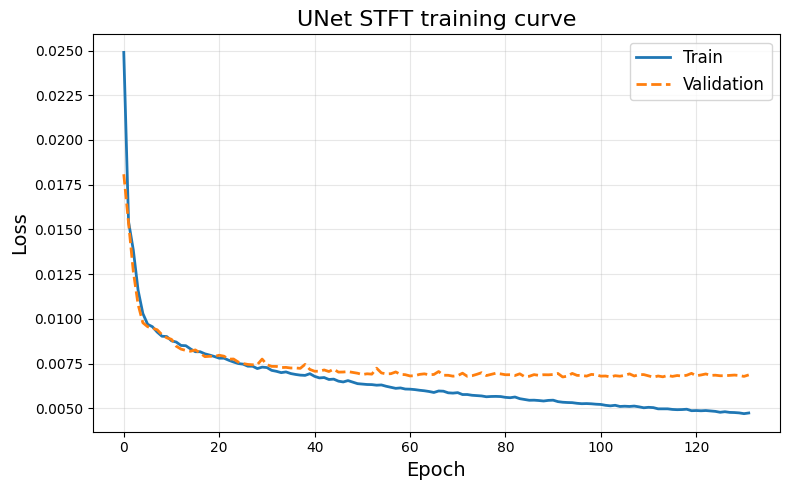

Test loss based on L1Loss: 0.0046
Test loss based on SNRLoss: 16.4468


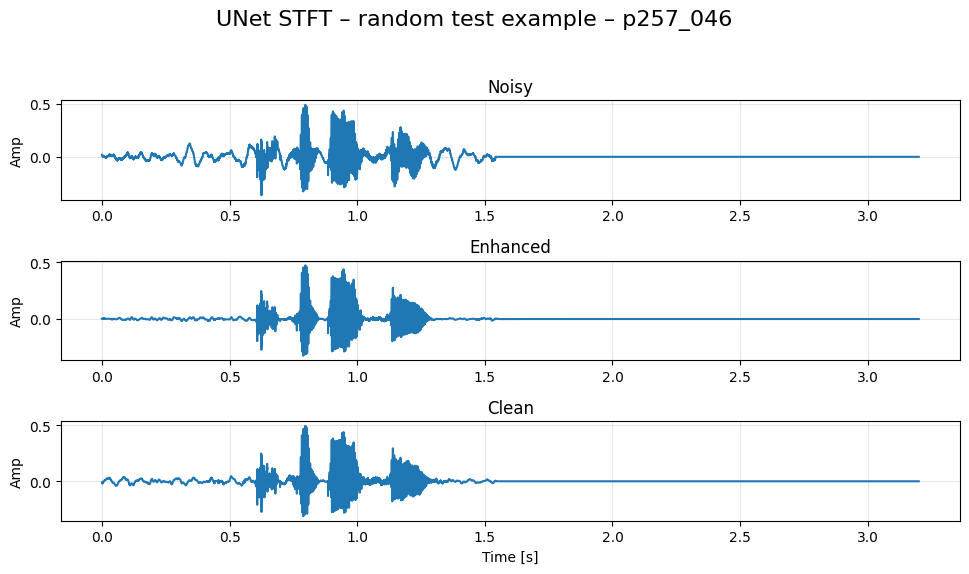

Noisy:


Enhanced:


Clean:


{'L1': 0.004645269538741559, 'SNR': 16.446816292676058}


In [ ]:
filename = 'Wave_UNet_L1Loss_20251209_154137'

eval_model = Wave_UNet()

results = evaluate_model(
    eval_model,
    filename,
    metrics,
    save_example=True,
    history_title="UNet STFT training curve",
    example_title="UNet STFT – random test example",
)
print(results)

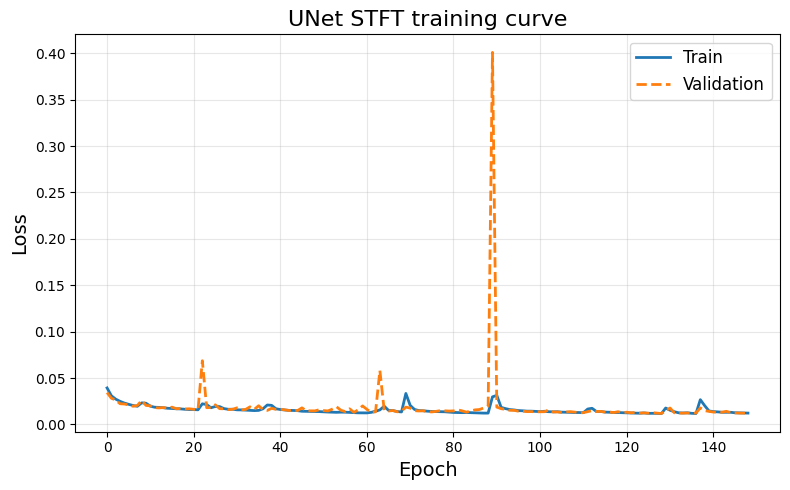

Test loss based on L1Loss: 0.0101
Test loss based on SNRLoss: 9.7044


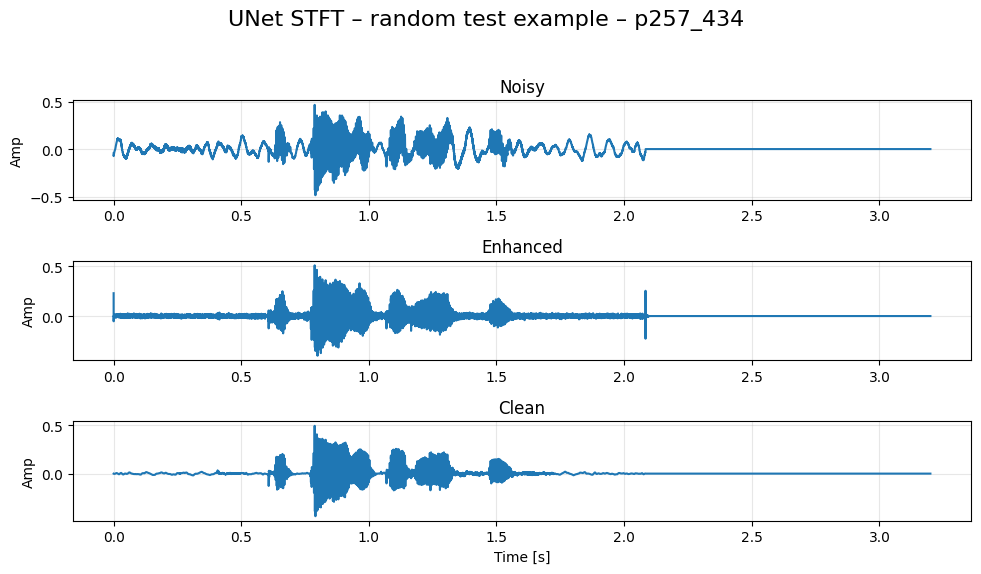

Noisy:


Enhanced:


Clean:


{'L1': 0.010071577895856039, 'SNR': 9.70436243577437}


In [ ]:
# filename = 'UNet_L1Loss_STFT_20251209_150638'
# metrics = {
#     "L1": nn.L1Loss(),
#     "SNR": SNRLoss(),
# }

# fwd = STFTLogPower(n_fft=1024, hop_length=160, win_length=400)
# inv = ISTFTFromLogPower(n_fft=1024, hop_length=160, win_length=400)
# eval_model = UNetStatic(forward_transform=fwd,inverse_transform=inv)

# # results = evaluate_model(eval_model, filename, metrics) default titles (use filename)

# results = evaluate_model(
#     eval_model,
#     filename,
#     metrics,
#     save_example=True,
#     history_title="UNet STFT training curve",
#     example_title="UNet STFT – random test example",
# )
# print(results)

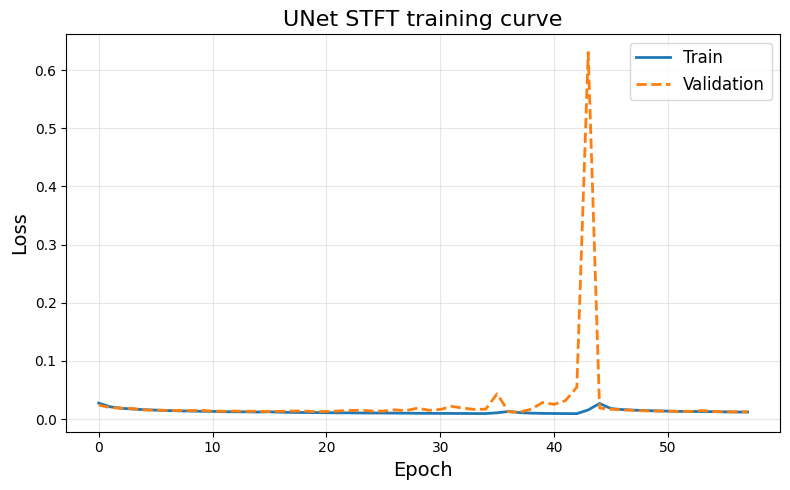

Test loss based on L1Loss: 0.0107
Test loss based on SNRLoss: 8.5971


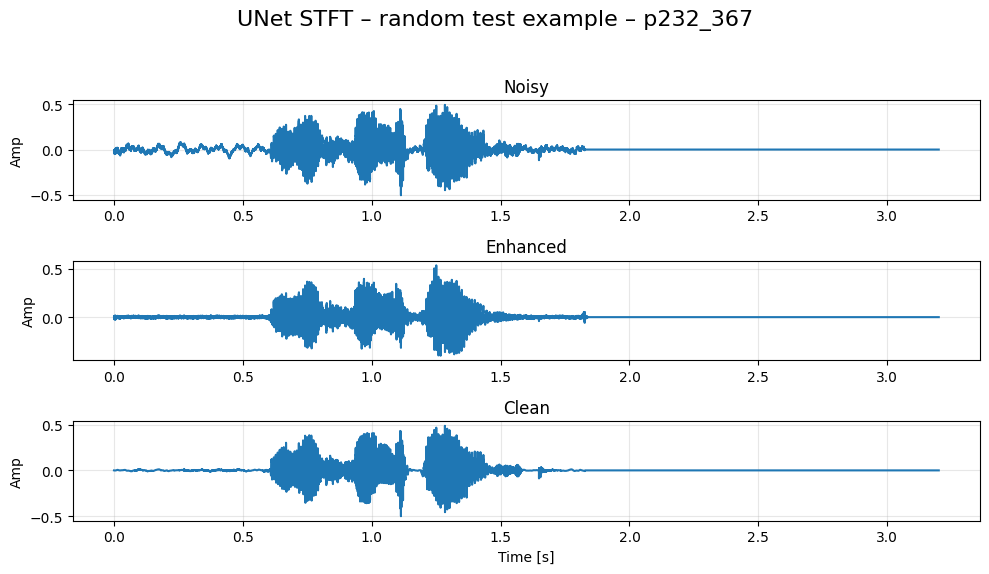

Noisy:


Enhanced:


Clean:


{'L1': 0.010732597883113405, 'SNR': 8.597143747589804}


In [ ]:
# filename = 'UNet_L1Loss_log-mel_20251209_151704'
# metrics = {
#     "L1": nn.L1Loss(),
#     "SNR": SNRLoss(),
# }

# fwd = MelLogMag(sample_rate=16000, n_fft=1024, hop_length=160, win_length=400, n_mels=128)
# inv = InvMelLogMag(sample_rate=16000, n_fft=1024, hop_length=160, win_length=400, n_mels=128)
# eval_model = UNetStatic(forward_transform=fwd,inverse_transform=inv)

# results = evaluate_model(
#     eval_model,
#     filename,
#     metrics,
#     save_example=True,
#     history_title="UNet STFT training curve",
#     example_title="UNet STFT – random test example",
# )
# print(results)

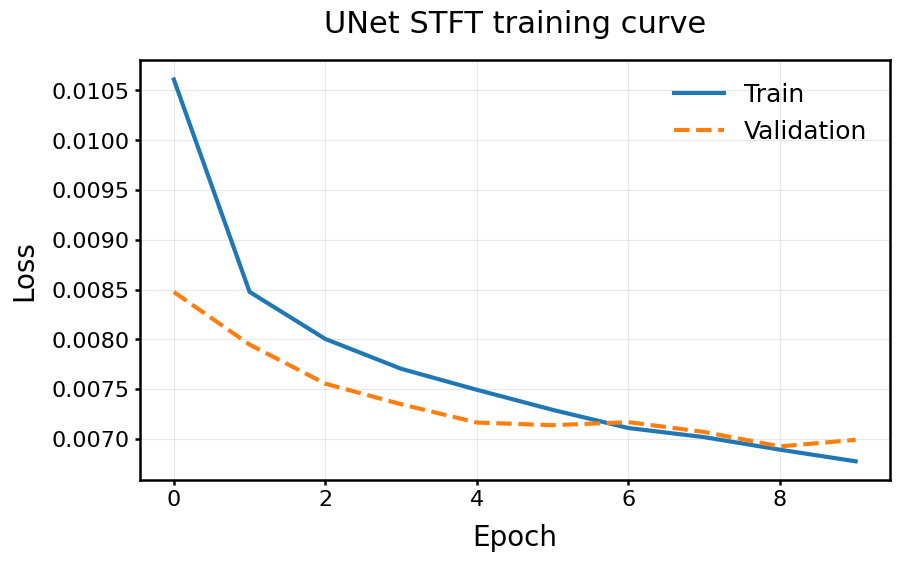

Test loss based on L1Loss: 0.0047
Test loss based on SNRLoss: 15.6408
Test loss based on PESQMetric: 2.1266
Test loss based on STOIMetric: 0.7877


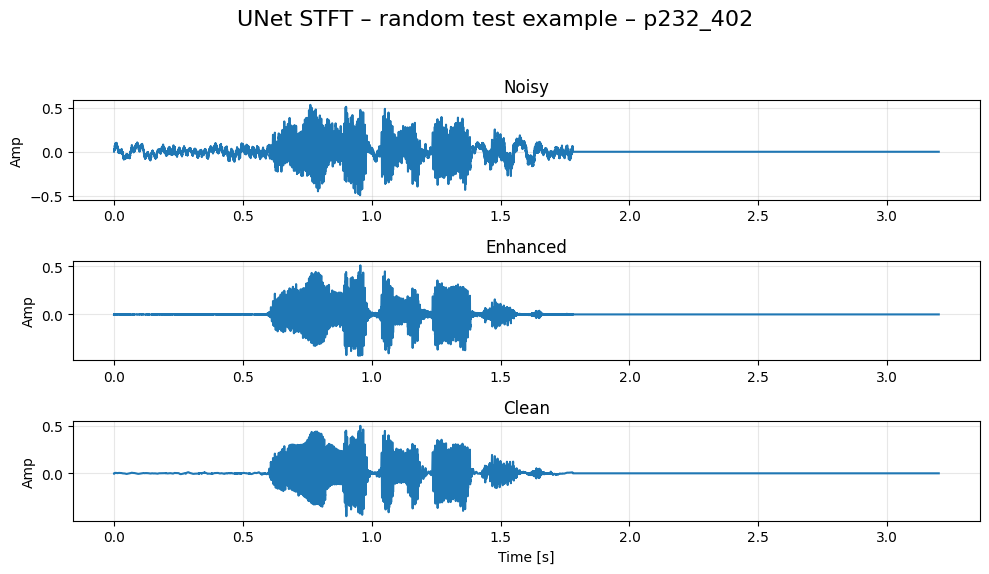

Noisy:


Enhanced:


Clean:


{'L1': 0.004699197656009346, 'SNR': 15.640808538957076, 'PESQ': 2.1265952614220707, 'STOI': 0.7877418900188146}


In [32]:
filename = 'UNet_STFT__L1Loss_20251209_182657' # 10 epochs
fwd = STFTMag(n_fft=1024, hop_length=160, win_length=400)
inv = ISTFTMask(n_fft=1024, hop_length=160, win_length=400)

eval_model = UNetStaticMask(
    forward_transform=fwd,
    inverse_transform=inv,
)

results = evaluate_model(
    eval_model,
    filename,
    metrics,
    save_example=False,
    history_title="UNet STFT training curve",
    example_title="UNet STFT – random test example",
)
print(results)

for real now

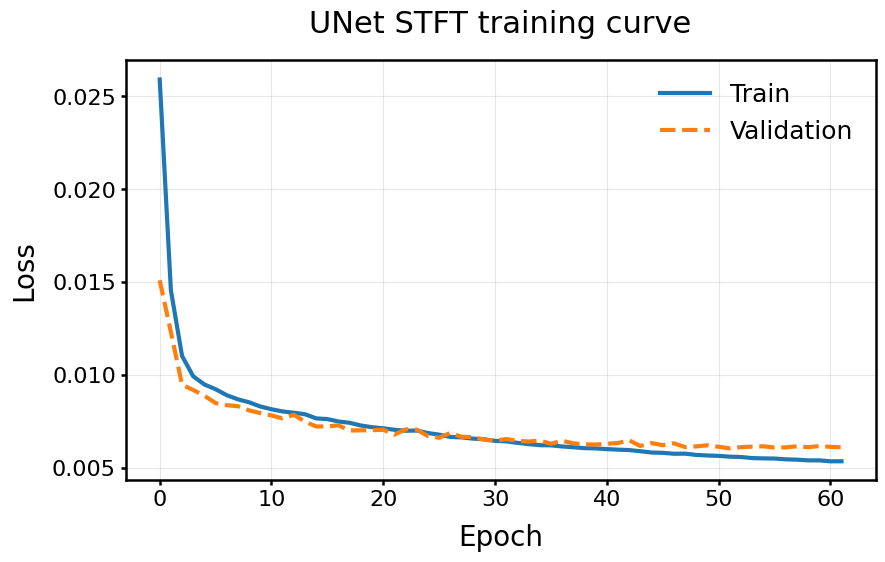

Test loss based on L1Loss: 0.0043
Test loss based on SNRLoss: 17.0136
Test loss based on PESQMetric: 2.2318
Test loss based on STOIMetric: 0.8003


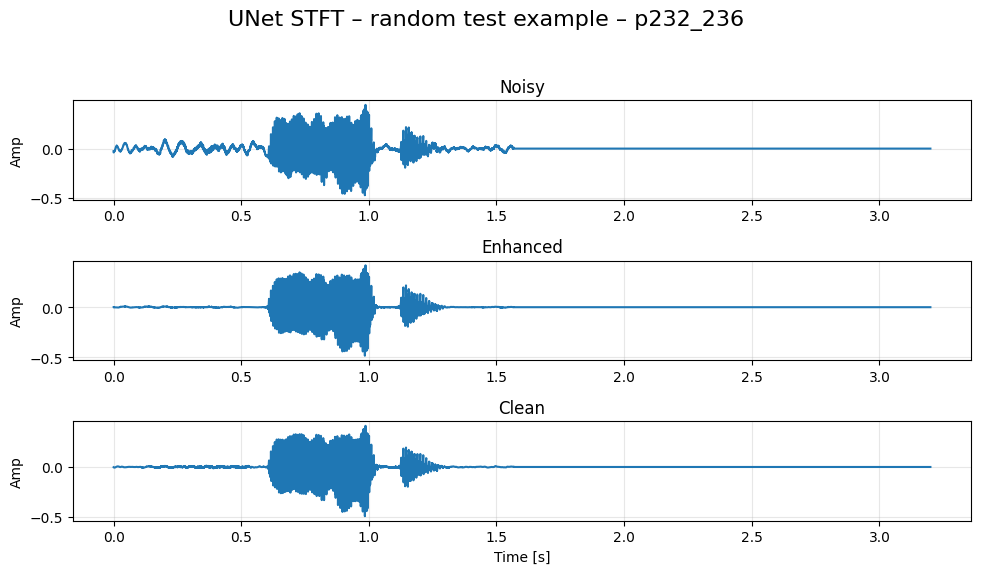

Noisy:


Enhanced:


Clean:


{'L1': 0.0043317613202485845, 'SNR': 17.013572974638507, 'PESQ': 2.2317619757218794, 'STOI': 0.8002626704469971}


In [29]:
filename = 'Wave_UNet__L1Loss_20251209_210408' 
eval_model = Wave_UNet()

results = evaluate_model(
    eval_model,
    filename,
    metrics,
    save_example=True,
    history_title="UNet STFT training curve",
    example_title="UNet STFT – random test example",
)
print(results)

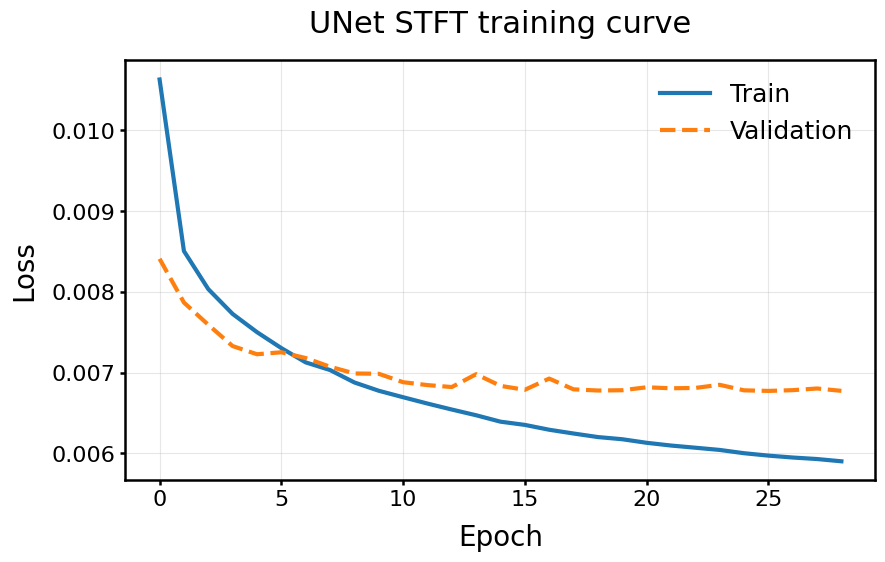

Test loss based on L1Loss: 0.0045
Test loss based on SNRLoss: 16.0071
Test loss based on PESQMetric: 2.1239
Test loss based on STOIMetric: 0.7894


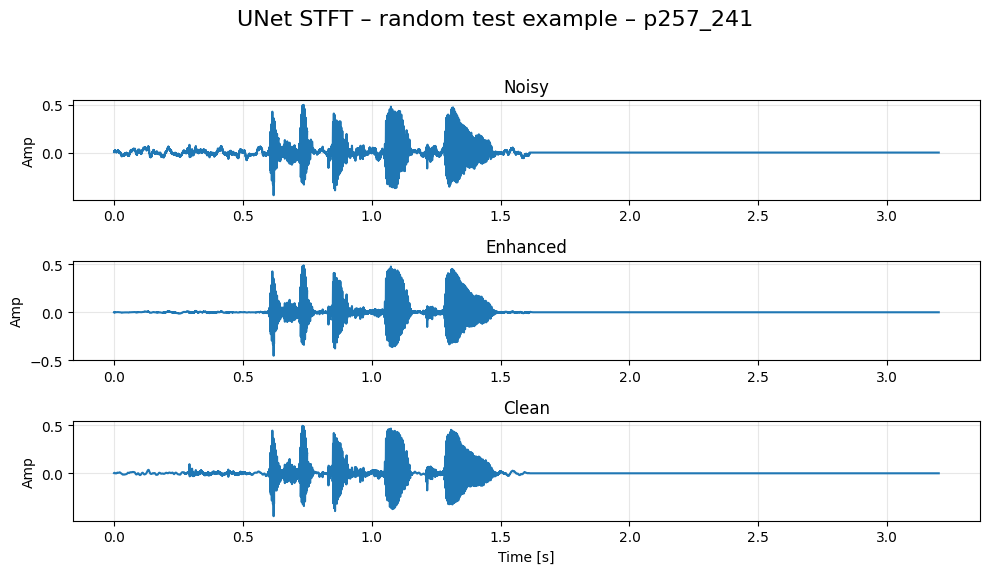

Noisy:


Enhanced:


Clean:


{'L1': 0.004528168424836953, 'SNR': 16.007122820073906, 'PESQ': 2.1239347241141577, 'STOI': 0.7893610627270259}


In [34]:
filename = 'UNet_STFT__L1Loss_20251209_215825'

fwd = STFTMag(n_fft=1024, hop_length=160, win_length=400)
inv = ISTFTMask(n_fft=1024, hop_length=160, win_length=400)

eval_model = UNetStaticMask(
    forward_transform=fwd,
    inverse_transform=inv,
)

results = evaluate_model(
    eval_model,
    filename,
    metrics,
    save_example=True,
    history_title="UNet STFT training curve",
    example_title="UNet STFT – random test example",
)
print(results)

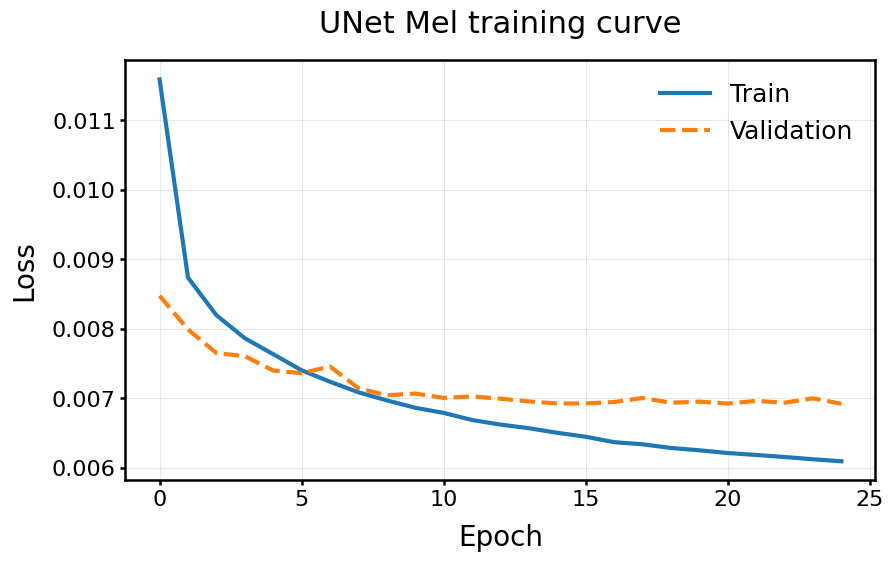

Test loss based on L1Loss: 0.0046
Test loss based on SNRLoss: 15.8679
Test loss based on PESQMetric: 2.0697
Test loss based on STOIMetric: 0.7885


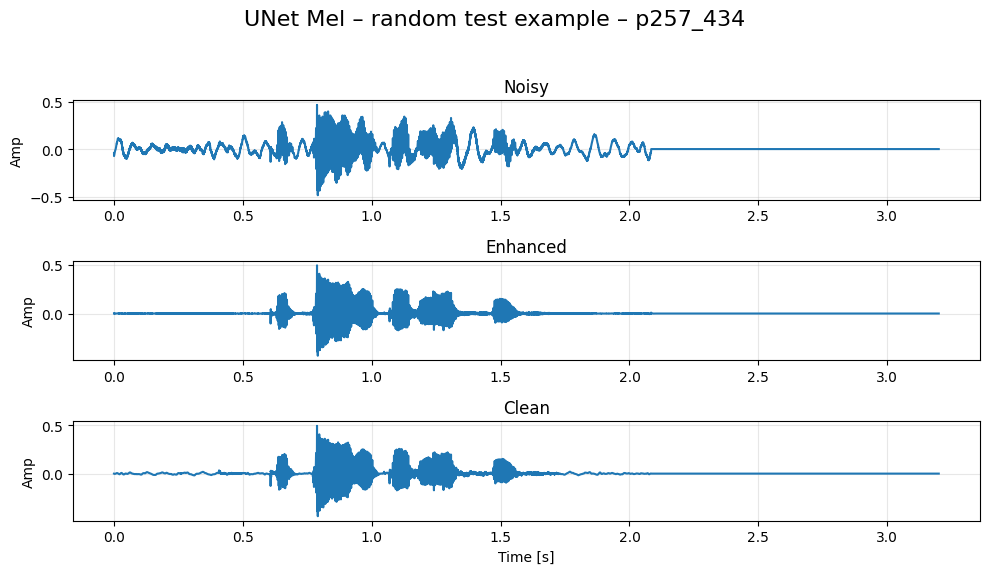

Noisy:


Enhanced:


Clean:


{'L1': 0.0046025689966468645, 'SNR': 15.867901953783901, 'PESQ': 2.0697027905420824, 'STOI': 0.7884860075985208}


In [33]:
filename = 'UNet_MEL__L1Loss_20251209_230337'

fwd_mel = MelMag(
    sample_rate=16000,
    n_fft=1024, hop_length=160, win_length=400,
    n_mels=128,
)
inv_mel = InvMelMagMask(
    sample_rate=16000,
    n_fft=1024, hop_length=160, win_length=400,
    n_mels=128,
)

eval_model = UNetStaticMask(
    forward_transform=fwd_mel,
    inverse_transform=inv_mel,
)

results = evaluate_model(
    eval_model,
    filename,
    metrics,
    save_example=True,
    history_title="UNet Mel training curve",
    example_title="UNet Mel – random test example",
)
print(results)

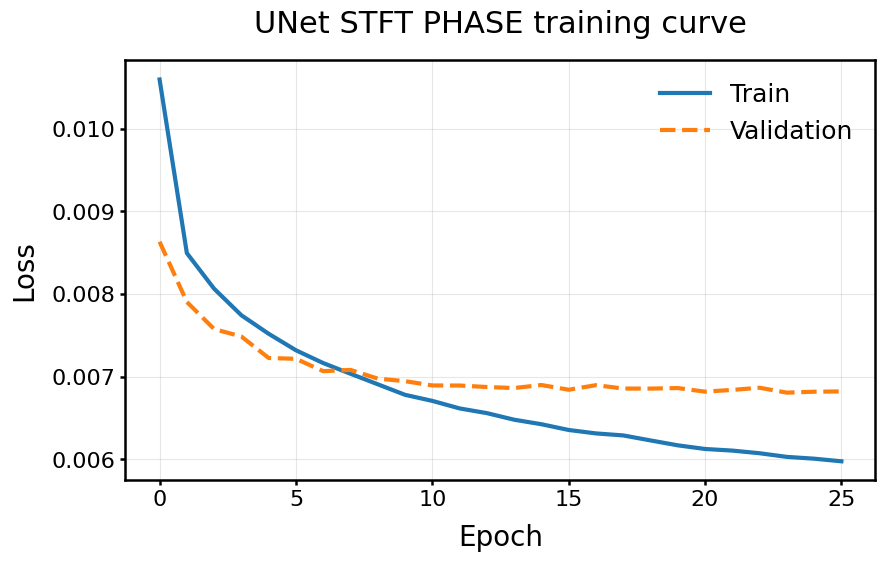

Test loss based on L1Loss: 0.0046
Test loss based on SNRLoss: 15.8565
Test loss based on PESQMetric: 2.1421
Test loss based on STOIMetric: 0.7835


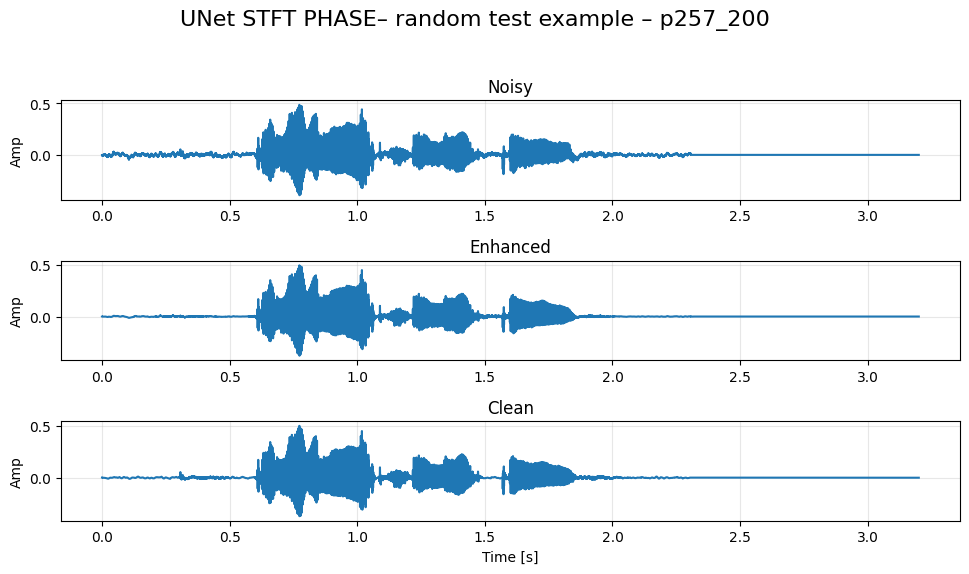

Noisy:


Enhanced:


Clean:


{'L1': 0.004586459074000066, 'SNR': 15.856545274907893, 'PESQ': 2.142118199305101, 'STOI': 0.7835239777297308}


In [38]:
filename = 'UNet_STFT_PHASE__L1Loss_20251209_232103'

fwd_phase = STFTMagPhase(n_fft=1024, hop_length=160, win_length=400)
inv_phase = ISTFTMaskFromAux(n_fft=1024, hop_length=160, win_length=400)

eval_model = UNetStaticMask(
    forward_transform=fwd_phase,
    inverse_transform=inv_phase,
    in_channels=3,   # mag, cos, sin
)

results = evaluate_model(
    eval_model,
    filename,
    metrics,
    save_example=True,
    history_title="UNet STFT PHASE training curve",
    example_title="UNet STFT PHASE– random test example",
)
print(results)